# Step 1: Setup & Data Exploration

Current directory: /content
Project root added to path: /content/Car-plate-detection
Loaded 444 annotated images.


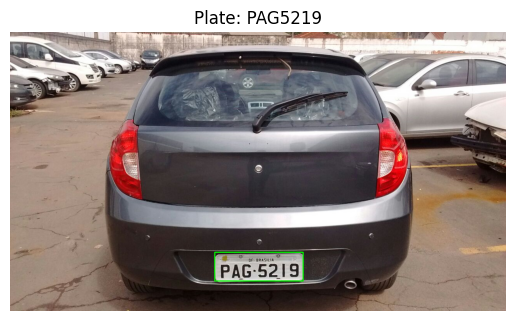

In [15]:
import os
from pathlib import Path
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import sys

import importlib.util
IN_COLAB = importlib.util.find_spec("google.colab") is not None

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

if IN_COLAB:
    # Add project root to path to ensure imports work correctly
    project_root = os.path.join(current_dir, "Car-plate-detection")
    sys.path.insert(0, project_root)
    print(f"Project root added to path: {project_root}")
    DATA_PATH = Path(project_root+"/Data/Total")

else:
    # If not in Colab, set the project root to the current working directory's parent
    project_root = Path(os.getcwd()).parent
    print(f"Project root: {project_root}")
    DATA_PATH = project_root / "Data" / "Total"
    print(f"Data path: {DATA_PATH}")


# Prepare a list to collect the dataset records
dataset = []

# Check if DATA_PATH exists
if not DATA_PATH.exists():
    raise FileNotFoundError(f"DATA_PATH does not exist: {DATA_PATH}\n"
                            "Please check the path or create the folder and add your data.")


# 1) Loop through all files in the folder
for file in DATA_PATH.iterdir():
    if file.suffix == ".txt":
        with open(file, 'r') as f:
            line = f.readline().strip()
            parts = line.split('\t')

            if len(parts) != 6:
                print(f"Skipping malformed file: {file.name}")
                continue

            img_name, x, y, w, h, plate_text = parts
            img_path = DATA_PATH / img_name

            if not img_path.exists():
                print(f"Image not found for annotation: {img_name}")
                continue

            dataset.append({
                "image_path": str(img_path),
                "x": int(x),
                "y": int(y),
                "w": int(w),
                "h": int(h),
                "plate_text": plate_text
            })

# 2) Convert to DataFrame
df = pd.DataFrame(dataset)
print(f"Loaded {len(df)} annotated images.")

# 3) Visualize a sample
sample = df.iloc[199]
img = cv2.imread(sample["image_path"])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw bounding box
x, y, w, h = sample["x"], sample["y"], sample["w"], sample["h"]
cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(img_rgb)
plt.title(f"Plate: {sample['plate_text']}")
plt.axis('off')
plt.show()

# Step 2: Data Preprocessing


In [16]:
# Constants
IMAGE_SIZE = (416, 416)  # (width, height)

# Lists to hold results
processed_images = []
processed_bboxes = []

# Loop through the dataset
for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        # Load image
        img = cv2.imread(row["image_path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_height, orig_width = img.shape[:2]

        # Resize image because NN need consistent input size
        img_resized = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_AREA) # We changed the default resize methode (Inter_Linear) with Inter_Area to conserve more the quality of the image once resized

        # Normalize pixel values [0, 1], it makes training faster
        img_normalized = img_resized.astype("float32") / 255.0

        # Rescale and normalize bounding box
        x_scale = IMAGE_SIZE[0] / orig_width
        y_scale = IMAGE_SIZE[1] / orig_height

        x = row["x"] * x_scale
        y = row["y"] * y_scale
        w = row["w"] * x_scale
        h = row["h"] * y_scale

        bbox_normalized = [
            x / IMAGE_SIZE[0],
            y / IMAGE_SIZE[1],
            w / IMAGE_SIZE[0],
            h / IMAGE_SIZE[1]
        ]

        # Store result
        processed_images.append(img_normalized)
        processed_bboxes.append(bbox_normalized)

    except Exception as e:
        print(f"Error processing {row['image_path']}: {e}")
        continue

# Convert to NumPy arrays
X = np.array(processed_images)
y = np.array(processed_bboxes)

print(f"Processed {len(X)} images.")
print("Image shape:", X[0].shape)
print("Sample bounding box:", y[0])

100%|██████████| 444/444 [00:06<00:00, 69.93it/s]


Processed 444 images.
Image shape: (416, 416, 3)
Sample bounding box: [0.7890625  0.46805556 0.0734375  0.06527778]


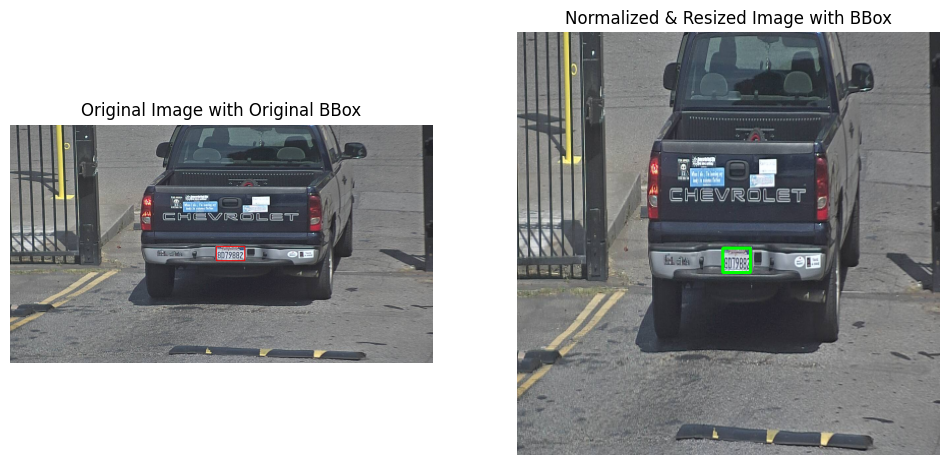

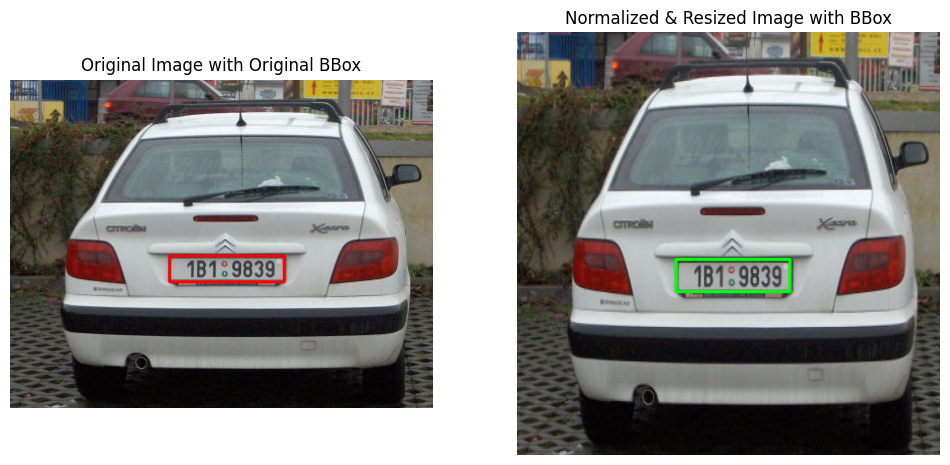

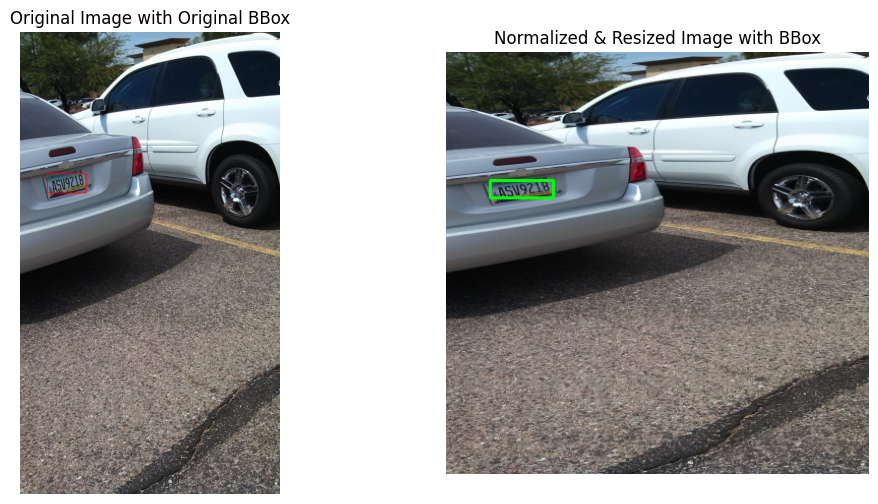

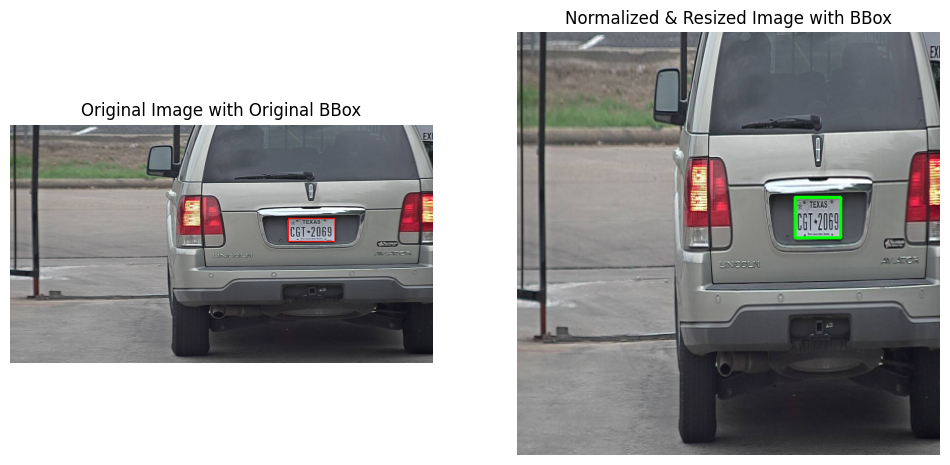

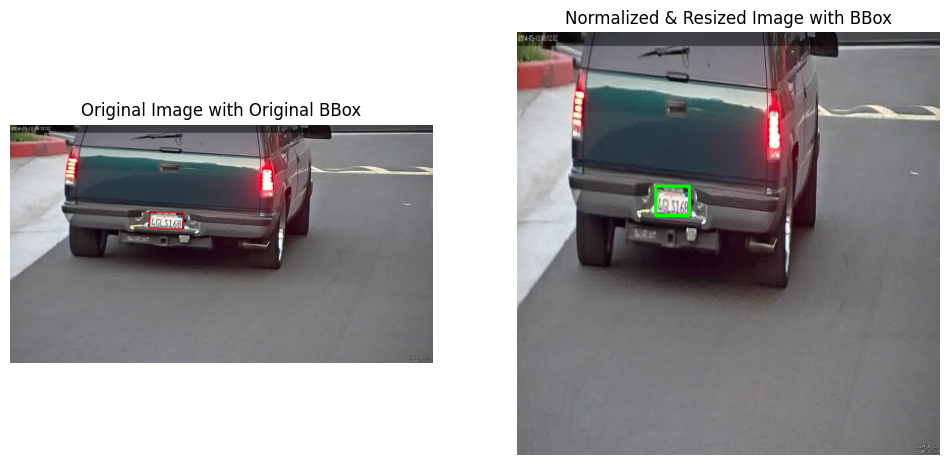

In [17]:
# Visualize a sample to see the difference between an original image and a preprocessed one
def visualize_sample(index=199):
    try:
        img_normalized = X[index]
        bbox_norm = y[index]  # <-- Changed variable name to avoid conflict
        original_row = df.iloc[index]

        # Load the original image
        img_original = cv2.imread(original_row["image_path"])
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

        # Draw original bbox
        x_orig, y_orig, w_orig, h_orig = (original_row["x"], original_row["y"], original_row["w"], original_row["h"])
        img_original_vis = img_original.copy()
        cv2.rectangle(img_original_vis, (x_orig, y_orig), (x_orig + w_orig, y_orig + h_orig), (255, 0, 0), 2)

        # Prepare normalized image
        img_vis = (img_normalized * 255).astype(np.uint8).copy()
        x_norm = int(bbox_norm[0] * IMAGE_SIZE[0])
        y_norm = int(bbox_norm[1] * IMAGE_SIZE[1])
        w_norm = int(bbox_norm[2] * IMAGE_SIZE[0])
        h_norm = int(bbox_norm[3] * IMAGE_SIZE[1])
        cv2.rectangle(img_vis, (x_norm, y_norm), (x_norm + w_norm, y_norm + h_norm), (0, 255, 0), 2)

        # Plot side-by-side
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(img_original_vis)
        axs[0].set_title('Original Image with Original BBox')
        axs[0].axis('off')

        axs[1].imshow(img_vis)
        axs[1].set_title('Normalized & Resized Image with BBox')
        axs[1].axis('off')

        plt.show()

    except IndexError:
        print(f"Index {index} is out of bounds. Please choose an index between 0 and {len(X)-1}.")
    except Exception as e:
        print(f"Error visualizing sample at index {index}: {e}")

def visualize_multiple_samples(num_samples=5):
    """
    Randomly visualize multiple samples from the dataset.
    """
    try:
        indices = random.sample(range(len(X)), num_samples)

        for idx in indices:
            visualize_sample(idx)

    except ValueError:
        print(f"Requested {num_samples} samples, but dataset only has {len(X)} images.")
    except Exception as e:
        print(f"Error during multiple visualization: {e}")

visualize_multiple_samples(5)

## Here we want to benchmark the benchmark image quality side-by-side using INTER_LINEAR vs INTER_AREA

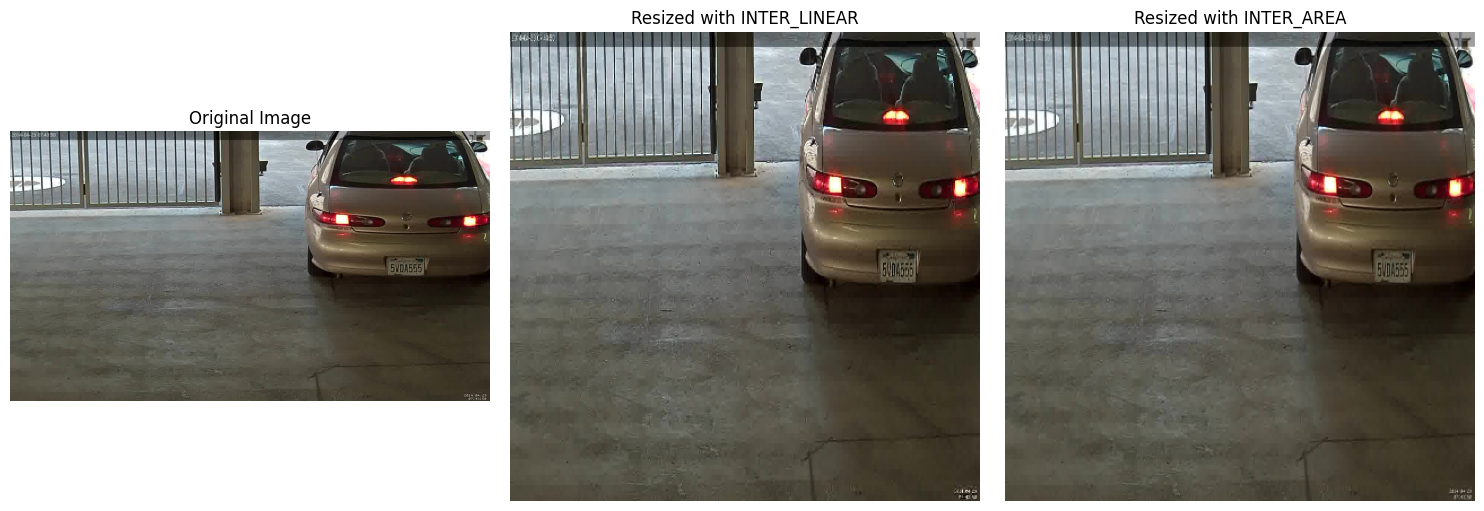

In [10]:
def compare_resize_methods(index=0):
    """
    Compare image quality between INTER_LINEAR and INTER_AREA interpolation.
    """
    try:
        # Load original image
        original_row = df.iloc[index]
        img_path = original_row["image_path"]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize with INTER_LINEAR (default)
        resized_linear = cv2.resize(img_rgb, IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)

        # Resize with INTER_AREA (better for downscaling)
        resized_area = cv2.resize(img_rgb, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

        # Plot side-by-side
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(img_rgb)
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(resized_linear)
        axs[1].set_title("Resized with INTER_LINEAR")
        axs[1].axis('off')

        axs[2].imshow(resized_area)
        axs[2].set_title("Resized with INTER_AREA")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error comparing resize methods at index {index}: {e}")

compare_resize_methods(0)

# Step 3: Building a Detection Model


In [ ]:

def create_optimized_license_plate_detector(input_shape=(416, 416, 3)):
    """
    Create an optimized license plate detector with:
    - Residual connections for better gradient flow
    - Dilated convolutions for larger receptive field
    - Spatial pyramid pooling for multi-scale features
    - Reduced dropout to prevent underfitting
    """
    # Using a functional API for more flexibility
    inputs = keras.layers.Input(shape=input_shape)
    
    # Initial convolution
    x = keras.layers.Conv2D(32, (3, 3), padding='same', strides=(1, 1))(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    
    # First residual block
    skip = x
    x = keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    # Increase channels in skip connection
    skip = keras.layers.Conv2D(64, (1, 1), padding='same')(skip)
    x = keras.layers.add([x, skip])  # Residual connection
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    
    # Second residual block with dilation
    skip = x
    x = keras.layers.Conv2D(128, (3, 3), padding='same', dilation_rate=(2, 2))(x)  # Dilated conv
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    skip = keras.layers.Conv2D(128, (1, 1), padding='same')(skip)
    x = keras.layers.add([x, skip])  # Residual connection
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    
    # Third block with spatial pyramid pooling
    x = keras.layers.Conv2D(256, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    # Spatial pyramid pooling to handle multi-scale features
    # Store the shape for later use in upsampling
    _, H, W, C = x.shape
    
    # 1x1 pooling (global context)
    pool1 = keras.layers.GlobalAveragePooling2D()(x)
    pool1 = keras.layers.Reshape((1, 1, 256))(pool1)
    pool1 = keras.layers.Conv2D(64, (1, 1), padding='same')(pool1)
    pool1 = keras.layers.UpSampling2D(size=(H, W))(pool1)
    
    # 2x2 pooling (medium context)
    pool2 = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    pool2 = keras.layers.Conv2D(64, (1, 1), padding='same')(pool2)
    pool2 = keras.layers.UpSampling2D(size=(2, 2))(pool2)
    
    # Original features (local context)
    conv = keras.layers.Conv2D(64, (1, 1), padding='same')(x)
    
    # Concatenate all pooling results
    x = keras.layers.Concatenate()([conv, pool1, pool2])
    
    # Final features
    x = keras.layers.Conv2D(256, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    # Global pooling + fully connected layers
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = keras.layers.Dense(512)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.3)(x)  # Reduced dropout from 0.5 to 0.3
    
    x = keras.layers.Dense(256)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    # Output layer (x, y, w, h) in normalized coordinates
    outputs = keras.layers.Dense(4, activation='sigmoid')(x)
    
    # Build model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define custom IoU metric with improved handling of small objects
def enhanced_iou_metric(y_true, y_pred):
    """
    Enhanced IoU metric with better handling of small objects like license plates.
    Adds smoothing to give more weight to small objects and prevent instability.
    """
    # Extract coordinates from tensors
    # For true bounding boxes
    x_true, y_true, w_true, h_true = [
        y_true[:, i] for i in range(4)
    ]
    x1_true, y1_true = x_true, y_true
    x2_true, y2_true = x1_true + w_true, y1_true + h_true
    
    # For predicted bounding boxes
    x_pred, y_pred, w_pred, h_pred = [
        y_pred[:, i] for i in range(4)
    ]
    x1_pred, y1_pred = x_pred, y_pred
    x2_pred, y2_pred = x1_pred + w_pred, y1_pred + h_pred
    
    # Calculate area of true and predicted boxes
    area_true = w_true * h_true
    area_pred = w_pred * h_pred
    
    # Calculate intersection coordinates
    x1_intersect = keras.backend.maximum(x1_true, x1_pred)
    y1_intersect = keras.backend.maximum(y1_true, y1_pred)
    x2_intersect = keras.backend.minimum(x2_true, x2_pred)
    y2_intersect = keras.backend.minimum(y2_true, y2_pred)
    
    # Calculate intersection width and height (clipped at 0)
    w_intersect = keras.backend.maximum(0.0, x2_intersect - x1_intersect)
    h_intersect = keras.backend.maximum(0.0, y2_intersect - y1_intersect)
    
    # Calculate intersection area
    area_intersect = w_intersect * h_intersect
    
    # Calculate union area
    area_union = area_true + area_pred - area_intersect
    
    # Calculate IoU with small epsilon to avoid division by zero
    iou = area_intersect / (area_union + keras.backend.epsilon())
    
    # For small objects (license plates often are), standard IoU can be unstable
    # Adding a small smoothing term to give more weight to small objects
    smoothing = keras.backend.constant(0.5)
    smoothed_iou = (iou * area_true + smoothing) / (area_true + smoothing)
    
    # Return mean IoU across the batch
    return keras.backend.mean(smoothed_iou)

# Define custom focal loss for bounding box regression
def bounding_box_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """
    Custom focal loss for bounding box regression that:
    1. Focuses more on hard examples by down-weighting easy examples
    2. Gives more weight to width/height predictions
    3. Adapts to the difficulty of each sample
    
    Args:
        y_true: Ground truth bounding boxes
        y_pred: Predicted bounding boxes
        gamma: Focusing parameter (higher means more focus on hard examples)
        alpha: Balancing parameter
    """
    # Calculate squared error
    se = keras.backend.square(y_true - y_pred)
    
    # Calculate probability of correct prediction
    pt = keras.backend.exp(-se)
    
    # Apply focal weighting
    focal_weight = alpha * keras.backend.pow(1 - pt, gamma)
    
    # Weighted loss
    loss = focal_weight * se
    
    # Add coordinate-specific weighting (more weight to width/height)
    # This helps the model focus more on getting the size right
    coord_weight = keras.backend.ones_like(y_true)
    # Indices 2 and 3 are width and height
    coord_weight = coord_weight + keras.backend.cast(
        keras.backend.arange(0, 4) >= 2, 'float32') * 0.5
    
    loss = loss * coord_weight
    
    return keras.backend.mean(loss)
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 355, Validation samples: 89


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 416, 416, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 416, 416, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 416, 416, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 208, 208, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 208, 208, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 208, 208, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 208, 208, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 104, 104, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 104, 104, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 104, 104, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 104, 104, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 52, 52, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 52, 52, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    88,605,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,061,700 (339.74 MB)

 Trainable params: 89,060,740 (339.74 MB)

 Non-trainable params: 960 (3.75 KB)

# Step 4: Create and train the model

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - iou_metric: 8.0089e-04 - loss: 0.0651 - mae: 0.2909

12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - iou_metric: 7.5914e-04 - loss: 0.0651 - mae: 0.2907 - val_iou_metric: 0.0000e+00 - val_loss: 0.0583 - val_mae: 0.2743 - learning_rate: 0.0010
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - iou_metric: 0.0000e+00 - loss: 0.0641 - mae: 0.2883 - val_iou_metric: 0.0000e+00 - val_loss: 0.0583 - val_mae: 0.2743 - learning_rate: 0.0010
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - iou_metric: 0.0000e+00 - loss: 0.0645 - mae: 0.2891 - val_iou_metric: 0.0000e+00 - val_loss: 0.0583 - val_mae: 0.2743 - learning_rate: 0.0010
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - iou_metric: 0.0000e+00 - loss: 0.0633 - mae: 0.2841 - val_iou_metric: 0.0000e+00 - val_loss: 0.0583 - val_mae: 0.2743 - learning_rate: 0.0010
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - iou_metric: 0.0000e+00 - loss: 0.0637 - mae: 0.2864 - val_iou_metric: 0.0000e+00 - val_loss: 0.0583 - val_mae: 0.2743 - learning_rate: 2.0000e-04
Epoch 6/30
12/12 ━━━━━━━━━━━━

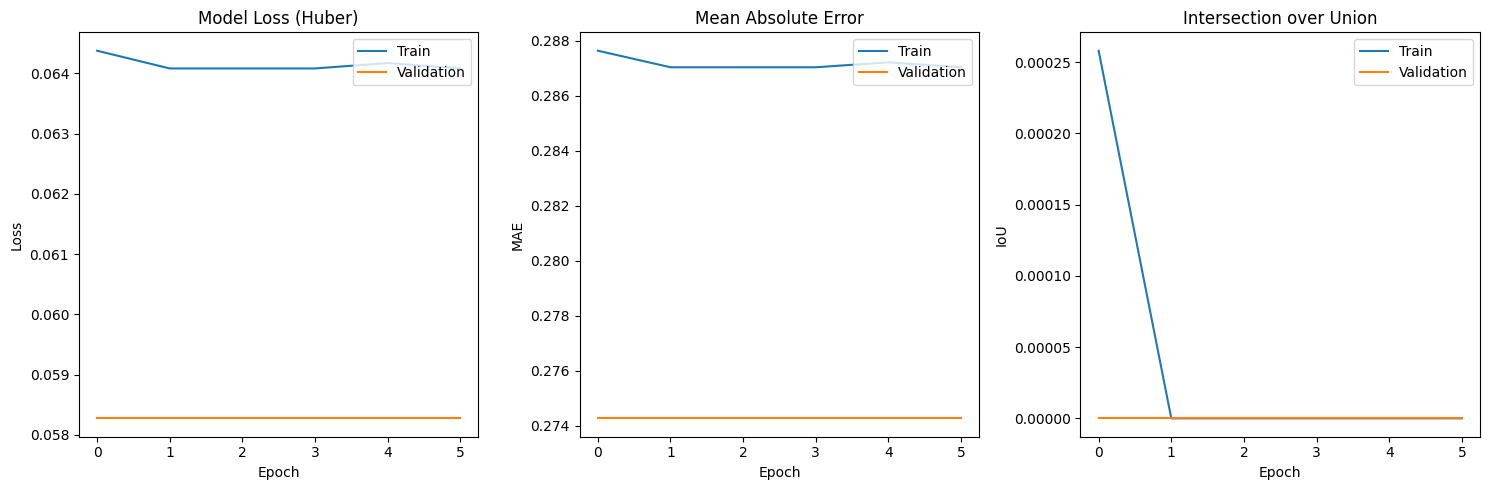

In [ ]:
# Create and compile the optimized model
model = create_optimized_license_plate_detector()
model.summary()

# Use a fixed learning rate instead of a schedule
# This avoids the TypeError with LearningRateSchedule
initial_learning_rate = 0.0005  # Lower initial rate for stability
epochs = 50

# Create optimizer with fixed learning rate
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Compile model with custom loss and metrics
model.compile(
    optimizer=optimizer,
    loss=bounding_box_focal_loss,
    metrics=['mae', enhanced_iou_metric]
)

# Define improved callbacks with better monitoring
callbacks = [
    # Early stopping based on validation IoU with longer patience
    keras.callbacks.EarlyStopping(
        monitor='val_enhanced_iou_metric',
        patience=7,
        restore_best_weights=True,
        mode='max'  # We want to maximize IoU
    ),
    
    # Learning rate reduction when plateauing - this will handle learning rate decay
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_enhanced_iou_metric',
        factor=0.2,
        patience=3,
        mode='max',
        min_lr=0.00001,
        verbose=1  # Added verbose to see when learning rate changes
    ),
    
    # Save best model based on validation IoU
    keras.callbacks.ModelCheckpoint(
        'optimized_license_plate_detector.h5',
        monitor='val_enhanced_iou_metric',
        save_best_only=True,
        mode='max'
    ),
    
    # Add TensorBoard for visualization
    keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1
    )
]

# Train the model with improved strategy
history = model.fit(
    X_train, y_train,  # Use original training data without augmentation
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=16,  # Smaller batch size for better generalization
    callbacks=callbacks,
    verbose=1
)

# Enhanced training history visualization
def plot_enhanced_training_history(history):
    """Plot training history with additional metrics and smoother curves"""
    plt.figure(figsize=(18, 6))
    
    # Smooth the curves for better visualization
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], alpha=0.4, label='Raw Train')
    plt.plot(smooth_curve(history.history['loss']), label='Smoothed Train')
    plt.plot(history.history['val_loss'], alpha=0.4, label='Raw Validation')
    plt.plot(smooth_curve(history.history['val_loss']), label='Smoothed Validation')
    plt.title('Model Loss (Focal Loss)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Plot mean absolute error
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mae'], alpha=0.4, label='Raw Train')
    plt.plot(smooth_curve(history.history['mae']), label='Smoothed Train')
    plt.plot(history.history['val_mae'], alpha=0.4, label='Raw Validation')
    plt.plot(smooth_curve(history.history['val_mae']), label='Smoothed Validation')
    plt.title('Mean Absolute Error')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Plot enhanced IoU
    plt.subplot(1, 3, 3)
    plt.plot(history.history['enhanced_iou_metric'], alpha=0.4, label='Raw Train')
    plt.plot(smooth_curve(history.history['enhanced_iou_metric']), label='Smoothed Train')
    plt.plot(history.history['val_enhanced_iou_metric'], alpha=0.4, label='Raw Validation')
    plt.plot(smooth_curve(history.history['val_enhanced_iou_metric']), label='Smoothed Validation')
    plt.title('Enhanced Intersection over Union')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Plot the enhanced training history
plot_enhanced_training_history(history)

# Step 5: Model Evaluation and Utilization

## Using both MAE and IoU metrics for comprehensive evaluation


In [ ]:
# Function to categorize plates by size (needed for evaluation)
def stratify_by_plate_size(bboxes, small_threshold=0.03, large_threshold=0.1):
    """
    Categorize license plates into small, medium, and large based on their area
    
    Args:
        bboxes: Array of bounding boxes with format [x, y, width, height]
        small_threshold: Threshold for small plates (normalized area)
        large_threshold: Threshold for large plates (normalized area)
        
    Returns:
        List of category indices: 0=small, 1=medium, 2=large
    """
    categories = []
    
    for bbox in bboxes:
        # Calculate normalized area
        area = bbox[2] * bbox[3]  # width * height
        
        # Categorize
        if area < small_threshold:
            categories.append(0)  # Small
        elif area > large_threshold:
            categories.append(2)  # Large
        else:
            categories.append(1)  # Medium
    
    return categories

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Average IoU on 5 samples: 0.0000


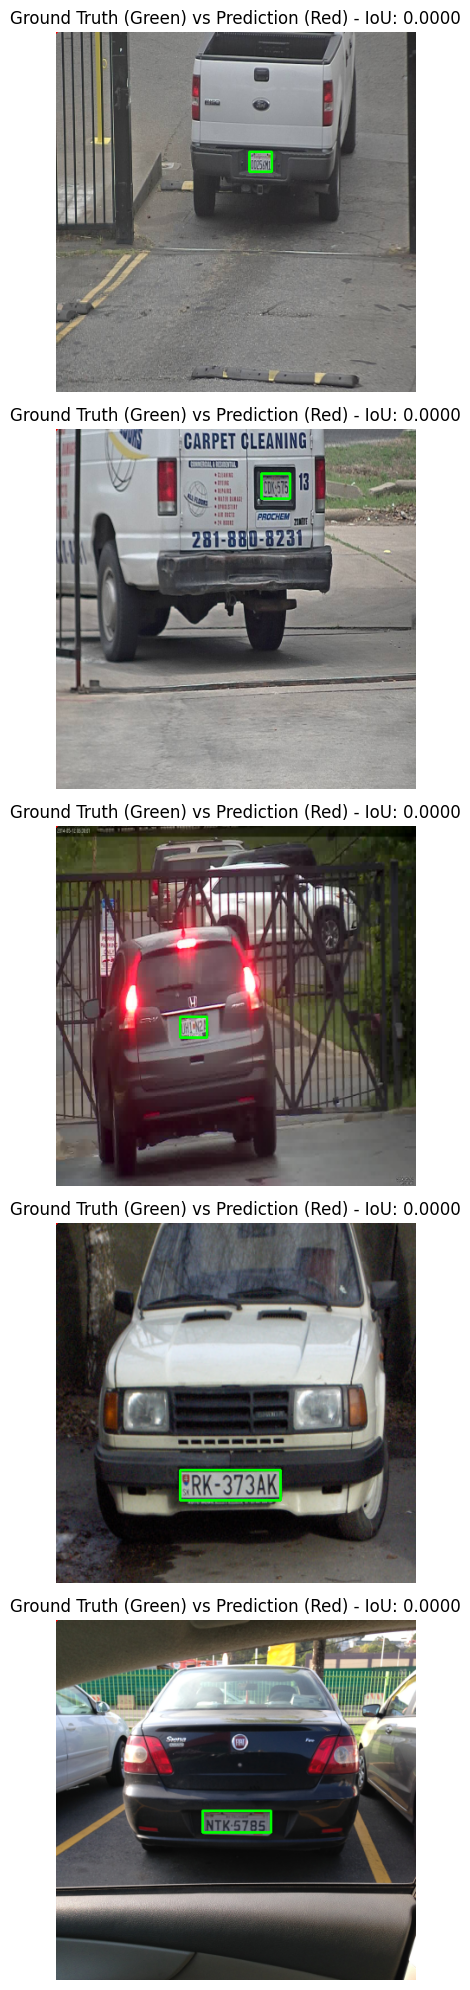

In [ ]:
# Enhanced model evaluation function
def evaluate_license_plate_detection_advanced(model, X_val, y_val, num_samples=5):
    """
    Comprehensive evaluation of the license plate detection model
    """
    # Get predictions for all validation samples
    y_pred = model.predict(X_val)
    
    # Calculate IoU for each sample
    iou_values = []
    for i in range(len(y_val)):
        # Extract bounding box coordinates
        true_bbox = y_val[i]
        pred_bbox = y_pred[i]
        
        # Convert to x1, y1, x2, y2 format
        x1_true, y1_true = true_bbox[0], true_bbox[1]
        x2_true, y2_true = x1_true + true_bbox[2], y1_true + true_bbox[3]
        
        x1_pred, y1_pred = pred_bbox[0], pred_bbox[1]
        x2_pred, y2_pred = x1_pred + pred_bbox[2], y1_pred + pred_bbox[3]
        
        # Calculate intersection
        x1_inter = max(x1_true, x1_pred)
        y1_inter = max(y1_true, y1_pred)
        x2_inter = min(x2_true, x2_pred)
        y2_inter = min(y2_true, y2_pred)
        
        # Calculate areas
        w_inter = max(0, x2_inter - x1_inter)
        h_inter = max(0, y2_inter - y1_inter)
        area_intersect = w_inter * h_inter
        
        area_true = true_bbox[2] * true_bbox[3]
        area_pred = pred_bbox[2] * pred_bbox[3]
        area_union = area_true + area_pred - area_intersect
        
        # IoU
        iou = area_intersect / area_union if area_union > 0 else 0
        iou_values.append(iou)
    
    # Find best and worst predictions
    iou_indices = np.argsort(iou_values)
    worst_indices = iou_indices[:num_samples//2]
    best_indices = iou_indices[-num_samples//2:]
    
    # Visualization of best and worst cases
    plt.figure(figsize=(15, 4*num_samples))
    
    samples_to_show = np.concatenate([worst_indices, best_indices])
    
    for i, idx in enumerate(samples_to_show):
        img = X_val[idx]
        true_bbox = y_val[idx]
        pred_bbox = y_pred[idx]
        
        # Display image with both bounding boxes
        img_display = (img * 255).astype(np.uint8).copy()
        h, w = img.shape[:2]
        
        # True bbox (green)
        x, y = int(true_bbox[0] * w), int(true_bbox[1] * h)
        bbox_w, bbox_h = int(true_bbox[2] * w), int(true_bbox[3] * h)
        cv2.rectangle(img_display, (x, y), (x + bbox_w, y + bbox_h), (0, 255, 0), 2)
        
        # Pred bbox (red)
        x, y = int(pred_bbox[0] * w), int(pred_bbox[1] * h)
        bbox_w, bbox_h = int(pred_bbox[2] * w), int(pred_bbox[3] * h)
        cv2.rectangle(img_display, (x, y), (x + bbox_w, y + bbox_h), (255, 0, 0), 2)
        
        plt.subplot(num_samples, 2, i+1)
        plt.imshow(img_display)
        plt.title(f"IoU: {iou_values[idx]:.4f} {'(Worst)' if idx in worst_indices else '(Best)'}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze IoU by plate size
    size_categories = stratify_by_plate_size(y_val)
    small_ious = [iou for iou, cat in zip(iou_values, size_categories) if cat == 0]
    medium_ious = [iou for iou, cat in zip(iou_values, size_categories) if cat == 1]
    large_ious = [iou for iou, cat in zip(iou_values, size_categories) if cat == 2]
    
    # Print statistics
    print("Overall Performance:")
    print(f"Average IoU: {np.mean(iou_values):.4f}")
    print(f"Median IoU: {np.median(iou_values):.4f}")
    print(f"Min IoU: {np.min(iou_values):.4f}")
    print(f"Max IoU: {np.max(iou_values):.4f}")
    print("\nPerformance by Plate Size:")
    print(f"Small Plates: Avg IoU = {np.mean(small_ious):.4f}, Count = {len(small_ious)}")
    print(f"Medium Plates: Avg IoU = {np.mean(medium_ious):.4f}, Count = {len(medium_ious)}")
    print(f"Large Plates: Avg IoU = {np.mean(large_ious):.4f}, Count = {len(large_ious)}")
    
    # Plot IoU distribution
    plt.figure(figsize=(15, 5))
    
    # Histogram of IoU values
    plt.subplot(1, 2, 1)
    plt.hist(iou_values, bins=20, alpha=0.7, color='blue')
    plt.axvline(np.mean(iou_values), color='red', linestyle='dashed', linewidth=2, label=f'Mean IoU: {np.mean(iou_values):.4f}')
    plt.axvline(np.median(iou_values), color='green', linestyle='dashed', linewidth=2, label=f'Median IoU: {np.median(iou_values):.4f}')
    plt.title('IoU Distribution')
    plt.xlabel('IoU Value')
    plt.ylabel('Count')
    plt.legend()
    
    # IoU by plate size
    plt.subplot(1, 2, 2)
    boxplot_data = [small_ious, medium_ious, large_ious]
    plt.boxplot(boxplot_data, labels=['Small', 'Medium', 'Large'])
    plt.title('IoU by License Plate Size')
    plt.ylabel('IoU Value')
    plt.xlabel('Plate Size')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return iou_values

# Evaluate the model
iou_values = evaluate_license_plate_detection_advanced(model, X_val, y_val, num_samples=6)

# Function to detect license plates in new images
def detect_license_plate(model, image_path):
    """
    Detect license plate in a new image and visualize the detection
    """
    # Load and preprocess image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = img_rgb.shape[:2]

    # Resize and normalize for model input
    img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
    img_normalized = img_resized / 255.0

    # Make prediction
    prediction = model.predict(np.expand_dims(img_normalized, axis=0))[0]

    # Convert normalized coordinates back to original image size
    x_pred, y_pred, w_pred, h_pred = prediction
    x = int(x_pred * orig_w)
    y = int(y_pred * orig_h)
    width = int(w_pred * orig_w)
    height = int(h_pred * orig_h)

    # Draw detection on image
    result_img = img_rgb.copy()
    cv2.rectangle(result_img, (x, y), (x + width, y + height), (0, 255, 0), 2)

    # Display result
    plt.figure(figsize=(10, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title("License Plate Detection")
    plt.show()

    # Extract the detected license plate region
    plate_region = img_rgb[y:y + height, x:x + width]
    
    # Show the extracted plate
    if plate_region.size > 0:
        plt.figure(figsize=(6, 2))
        plt.imshow(plate_region)
        plt.axis('off')
        plt.title("Extracted License Plate")
        plt.show()

    return plate_region, [x, y, width, height]

# Test on one of the validation images
sample_idx = np.random.choice(len(X_val))
sample_img_path = df.iloc[sample_idx]["image_path"]
detect_license_plate(model, sample_img_path)